## Data Quality Assurance Solution for “News Events” Dataset

### Import Libraries

In [1]:
# import required libraries
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
# Set display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 180)

### Common Function

In [3]:
def safe_hashable(val):
    if isinstance(val, (list, dict)):
        return json.dumps(val, sort_keys=True)
    return val

This function makes unhashable data types (like Python lists or dictionaries) hashable, so they can be safely compared or checked for duplicates in a DataFrame.

Need:
    
    - Pandas operations like .duplicated() or .nunique() require data that’s hashable (i.e., can be converted to a unique, comparable value).

    - Lists ([]) and dictionaries ({}) are mutable — meaning they can’t be directly hashed or compared reliably.

    - Without this conversion, Pandas will throw an error like: TypeError: unhashable type: 'list'

## Data Understanding & Profiling

### 1. Data Exploration

In [4]:
# Setup paths
BASE_DIR = "/Users/deepti.gautam/Documents/Scrapers/Notebook/Analysis/Assignment/Firmable"
RAW_DIR = os.path.join(BASE_DIR, "data", "raw_json")
OUTPUT_DIR = os.path.join(BASE_DIR, "data/processed")

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [5]:
# Load and Combine JSONL Files
records = []
json_files = glob.glob(os.path.join(RAW_DIR, "*.jsonl"))
print(f"Found {len(json_files)} JSONL files")

for file_path in json_files:
    with open(file_path, "r", encoding="utf-8") as infile:
        for line in infile:
            if not line.strip():
                continue
            try:
                data = json.loads(line)
                if "data" in data:
                    for item in data["data"]:
                        rec = {}
                        attrs = item.get("attributes", {})
                        rel = item.get("relationships", {})

                        for k, v in attrs.items():
                            rec[k] = v

                        rec["id"] = item.get("id")
                        rec["company_id"] = rel.get("company1", {}).get("data", {}).get("id")
                        rec["source_id"] = rel.get("most_relevant_source", {}).get("data", {}).get("id")

                        records.append(rec)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

df = pd.DataFrame(records)
print(f"Combined dataset shape: {df.shape}")

Found 24 JSONL files
Combined dataset shape: (620785, 32)


In [6]:
df.head(5)

,summary,category,found_at,confidence,article_sentence,human_approved,planning,amount,amount_normalized,assets,assets_tags,award,contact,division,effective_date,event,financing_type,financing_type_normalized,financing_type_tags,headcount,job_title,job_title_tags,location,location_data,product,product_data,product_tags,recognition,vulnerability,id,company_id,source_id
0,Unmudl Public Benefit Corp. partnered with Ama...,partners_with,2025-02-20T00:00:00Z,1.0000,In 2022 Unmudl partnered with Amazon and Centr...,True,False,None,NaN,None,[],None,None,None,2022-01-01,None,None,None,[],NaN,None,[],None,[],None,"{'full_text': None, 'name': None, 'release_typ...",[],None,None,49c2548f-7a5b-45e3-9bbc-84477e7fd0d0,5c5eebf0-3641-5525-b95a-ea2b75e0e508,c2fad223-cfcb-403f-ae2b-a7617502254f
1,"Sean Scott left Amazon.com, Inc. on Dec 6th '20.",leaves,2021-01-06T13:33:31Z,0.7669,Sean Scott is joining the IT incident software...,False,False,None,NaN,None,[],None,Sean Scott,None,2020-12-06,None,None,None,[],NaN,None,[],None,[],None,"{'full_text': None, 'name': None, 'release_typ...",[],None,None,49c25f6f-ef44-406e-ba54-37b4530e1642,None,bdeefec3-6f46-42df-ac18-6e29bb7cad90
2,ReverseLogix Corp. identified as competitor of...,identified_as_competitor_of,2020-06-05T05:17:56Z,0.7752,In part one of this blog post ReverseLogix wen...,False,False,None,NaN,None,[],None,None,None,None,None,None,None,[],NaN,None,[],None,[],None,"{'full_text': None, 'name': None, 'release_typ...",[],None,None,49c9867f-4c20-4be9-b11a-e7b8c9a71ccb,af50948a-e2b3-55b8-85c4-6a9881a55ec2,283b2f14-af15-4415-9901-57a2d8452f4f
3,"Harness Inc. partnered with Amazon.com, Inc. o...",partners_with,2019-04-23T09:00:11Z,0.7494,Harness recently announced that is has teamed ...,False,False,None,NaN,None,[],None,None,None,2019-03-23,None,None,None,[],NaN,None,[],None,[],None,"{'full_text': None, 'name': None, 'release_typ...",[],None,None,49cd397d-1fa6-4c20-beb5-622d9ec185c3,caa07793-a6e6-5e12-84c8-c6f88e68a965,613339f2-aa1e-4eaf-882c-21359769eea9
4,"Warner Bros partnered with Amazon.com, Inc. on...",partners_with,2017-11-13T11:07:08Z,0.6617,Warner Bros. has also teamed up with Amazon to...,False,False,None,NaN,None,[],None,None,None,2018-12-03,None,None,None,[],NaN,None,[],None,[],None,"{'full_text': None, 'name': None, 'release_typ...",[],None,None,49d417d9-2798-45cb-a208-52ed65329797,3bdf4a75-91d8-54b3-9c8a-d626b1a12864,c69740ec-4538-4dd3-8f31-dddd90735d88


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620785 entries, 0 to 620784
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   summary                    620785 non-null  object 
 1   category                   620785 non-null  object 
 2   found_at                   620785 non-null  object 
 3   confidence                 620777 non-null  float64
 4   article_sentence           620785 non-null  object 
 5   human_approved             620785 non-null  bool   
 6   planning                   620785 non-null  bool   
 7   amount                     42054 non-null   object 
 8   amount_normalized          42050 non-null   float64
 9   assets                     15682 non-null   object 
 10  assets_tags                620785 non-null  object 
 11  award                      18986 non-null   object 
 12  contact                    88282 non-null   object 
 13  division                   0 

📘 Dataset Overview

    The dataset contains company event and lead records extracted from multiple JSONL files.
Each record captures a business event such as a partnership, leadership change, or market movement between companies.

Dataset Structure:

    - Total records: 620785

    - Total columns: 32

Business Relevance:

    This dataset helps business intelligence, marketing, and sales teams monitor external signals of company activity

### 2. Data Profiling  


#### EDA (Exploratory Data Analysis)


 Event Categories Distribution:


launches               199986
partners_with          124175
hires                   65431
invests_into            26196
recognized_as           25103
is_developing           20850
receives_award          18985
acquires                18726
invests_into_assets     14405
has_issues_with         12501
Name: category, dtype: int64

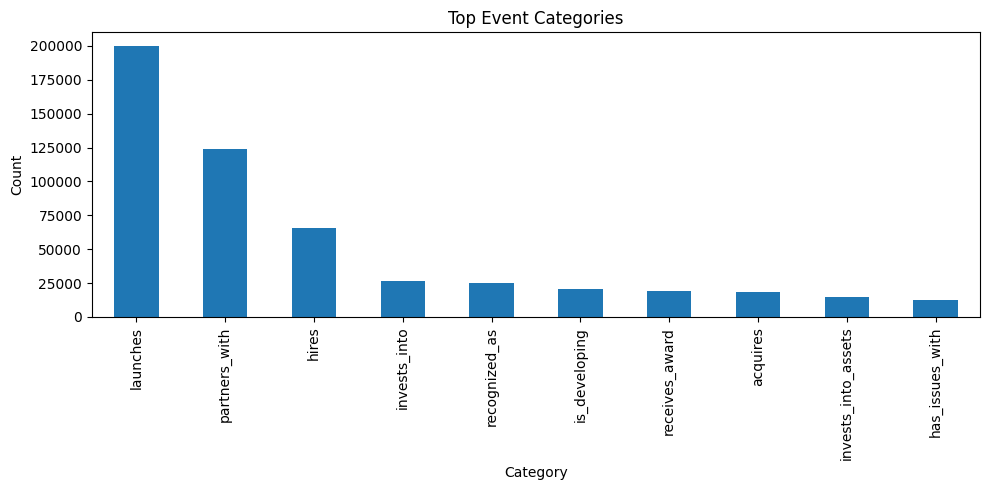

In [28]:
#Event Type Exploration -- top 10 most feq event categories
if "category" in df.columns:
    print("\n Event Categories Distribution:")
    cat_counts = df["category"].value_counts().head(10)
    display(cat_counts)

    plt.figure(figsize=(10,5))
    cat_counts.plot(kind="bar")
    plt.title("Top Event Categories")
    plt.ylabel("Count")
    plt.xlabel("Category")
    plt.tight_layout()
    plt.show()

This section:

 - Checks for the presence of a "category" column.

 - Calculates and displays the top 10 most frequent event types.

 - Visualizes their distribution using a simple, clean bar chart.

 - These event categories are highly valuable for Business development teams and Competitive intelligence analysts, to monitor rival activity.

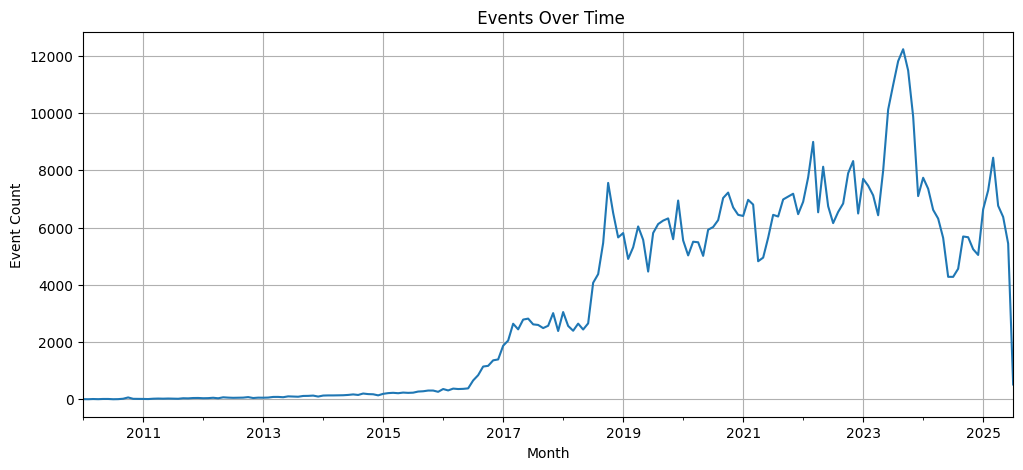

In [30]:
# Convert dates
for col in ["found_at", "published_at"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Events over time
if "found_at" in df.columns and not df["found_at"].isna().all():
    df["year_month"] = df["found_at"].dt.to_period("M")
    timeline = df["year_month"].value_counts().sort_index()

    plt.figure(figsize=(12,5))
    timeline.plot()
    plt.title(" Events Over Time")
    plt.ylabel("Event Count")
    plt.xlabel("Month")
    plt.grid(True)
    plt.show()

This block:

 - Converts date columns into datetime objects.

 - Extracts the month and year.

 - Counts how many events happened each month.

 - Plots an “Events Over Time” trend chart.

 - This temporal trend helps:
     Analysts identify emerging periods of high business activity
     Sales and marketing teams time their outreach when company momentum is high

In [32]:
# Frequency distributions for top categorical fields
categorical_cols = ["category", "financing_type", "event", "location"]

for col in categorical_cols:
    if col in df.columns:
        print(f"\nTop values for '{col}':")
        print(df[col].value_counts(dropna=False).head(10))



Top values for 'category':
launches               199986
partners_with          124175
hires                   65431
invests_into            26196
recognized_as           25103
is_developing           20850
receives_award          18985
acquires                18726
invests_into_assets     14405
has_issues_with         12501
Name: category, dtype: int64

Top values for 'financing_type':
NaN                        610286
grant                        1402
funding                      1090
Series A                      641
IPO                           604
initial public offering       552
Series B                      511
Seed                          455
investment                    365
Series C                      338
Name: financing_type, dtype: int64

Top values for 'event':
NaN                          602216
CES 2025                        152
CES                              63
Mobile World Congress            29
Computex 2025                    24
NAB 2025                     

#### Profiling

This section of code performs data profiling, i.e., it generates a quick statistical overview of the dataset to understand data quality, structure, and potential issues.

In [10]:
# Function: safe_nunique()
def safe_nunique(series):
    """Safely compute nunique even if column contains lists/dicts."""
    try:
        return series.apply(
            lambda x: json.dumps(x, sort_keys=True) if isinstance(x, (list, dict)) else x
        ).nunique()
    except Exception:
        return np.nan

Function: safe_nunique() handles unhashable types like lists or dicts.

In [31]:
# Creating the Data Profile Summary
profile = pd.DataFrame({
    "dtype": df.dtypes,
    "missing_%": df.isna().mean() * 100,
    "unique_values": [safe_nunique(df[col]) for col in df.columns]
}).sort_values("missing_%", ascending=False)

print("Data Profiling Summary:")
display(profile.head(15))

# Summary statistics for numeric columns
num_summary = df.describe(include=[np.number]).T
display(num_summary)

# Save profile
profile_path = os.path.join(OUTPUT_DIR, "data_profile.csv")
profile.to_csv(profile_path, index=True)

Data Profiling Summary:


,dtype,missing_%,unique_values
division,object,100.000000,0
financing_type_normalized,object,99.601150,28
headcount,float64,98.995949,698
financing_type,object,98.308754,1210
vulnerability,object,97.986259,9657
assets,object,97.473844,10145
event,object,97.008787,15277
award,object,96.941614,16536
recognition,object,95.956249,22237
amount_normalized,float64,93.226318,8246


,count,mean,std,min,25%,50%,75%,max
confidence,620777.0,6.033846e-01,2.709550e-01,0.000000e+00,4.487000e-01,6.481000e-01,7.987000e-01,1.000000e+00
amount_normalized,42050.0,3.350183e+10,4.397934e+12,-6.000000e+09,4.307750e+06,3.500000e+07,2.280000e+08,7.500000e+14
headcount,6233.0,9.789057e+03,5.827939e+04,-1.000000e+01,1.000000e+02,2.550000e+02,1.000000e+03,1.750000e+06


📊 <b>Data Profiling Insights</b>


<b>Data Completeness</b>

    The dataset contains a large number of fields, but many are sparsely populated. Columns such as division, financing_type, event, award, and recognition have more than 90% missing values, suggesting they are context-specific (e.g., only applicable to certain event types like funding or awards).

    Core columns like summary, category, found_at, and confidence are well-populated and form the core analytical base of the dataset.


<b>Uniqueness and Structure</b>

    High distinct counts in columns like product, contact, and job_title indicate entity-level granularity, with each record tied to unique people, roles, or products.

    Identifier columns (id, company_id, source_id) maintain uniqueness, confirming proper record-level integrity.


<b>Categorical Distributions</b>

    Dominant event types include categories like partners_with, leaves, and identified_as_competitor_of (based on earlier charts).

    These events span partnerships, leadership movements, and competitive signals, making the dataset valuable for business development and competitive intelligence.
 

### 3. Data Quality Analysis

In [33]:
# 1.Completeness
completeness = (1 - df.isna().mean()) * 100
completeness_summary = completeness.mean()

This calculates the percentage of non-null values for each column and then takes the average.

In [15]:
# 2.Uniqueness
df_clean = df.applymap(safe_hashable)
total_rows = len(df_clean)
duplicate_rows = df_clean.duplicated().sum()
dup_rate = (duplicate_rows / total_rows) * 100 if total_rows else 0
uniqueness_rate = 100 - dup_rate

Ensures each record in the dataset represents a distinct entity (no duplicates).

In [16]:
# 3.Consistency
if "amount_normalized" in df.columns and "amount" in df.columns:
    consistent_rows = df[
        (df["amount_normalized"].notna() & df["amount"].notna())
        | (df["amount_normalized"].isna() & df["amount"].isna())
    ]
    consistency_rate = (len(consistent_rows) / len(df)) * 100 if len(df) else np.nan
else:
    consistency_rate = np.nan

- Checks if related fields agree logically with each other.
- It verifies that when both amount and amount_normalized exist, they are either both null or both populated.

In [17]:
# 4.Validity
if "headcount" in df.columns:
    invalid_headcount = df[(df["headcount"] < 0) | (df["headcount"] > 1e6)]
    validity_rate = 100 - (len(invalid_headcount) / len(df) * 100)
else:
    validity_rate = np.nan

Measures if values fall within acceptable and logical ranges.

In [18]:
# 5.Timeliness

if "found_at" in df.columns:
    df["found_at"] = pd.to_datetime(df["found_at"], errors="coerce", utc=True)
    df["found_at"] = df["found_at"].dt.tz_localize(None)
    recent_events = df[df["found_at"] > pd.Timestamp("2024-01-01")]
    timeliness_rate = len(recent_events) / len(df) * 100 if len(df) else 0
else:
    timeliness_rate = np.nan

Indicates whether the data is recent and updated.

In [19]:
# 6.Accuracy
if "company_id" in df.columns and "source_id" in df.columns:
    valid_accuracy = df[(df["company_id"].notna()) | (df["source_id"].notna())]
    accuracy_rate = len(valid_accuracy) / len(df) * 100 if len(df) else np.nan
else:
    accuracy_rate = np.nan

Measures correctness of information (fields that can be verified).

In [34]:
# Final data quality summary
quality_summary = pd.DataFrame({
    "Metric": [
        "Completeness (%)",
        "Uniqueness (%)",
        "Consistency (%)",
        "Validity (%)",
        "Timeliness (%)",
        "Accuracy (%)",
        "Invalid_Records"
    ],
    "Value": [
        round(completeness_summary, 2),
        round(uniqueness_rate, 2),
        round(consistency_rate, 2),
        round(validity_rate, 2),
        round(timeliness_rate, 2),
        round(accuracy_rate, 2),
        int(df.isna().sum().sum())
    ]
})

print("\n✅ FINAL DATA QUALITY SUMMARY:\n")
display(quality_summary)

# Save summary
summary_path = os.path.join(OUTPUT_DIR, "data_quality_summary.csv")
quality_summary.to_csv(summary_path, index=False)



✅ FINAL DATA QUALITY SUMMARY:



,Metric,Value
0,Completeness (%),56.28
1,Uniqueness (%),98.73
2,Consistency (%),100.00
3,Validity (%),100.00
4,Timeliness (%),17.71
5,Accuracy (%),100.00
6,Invalid_Records,8955872.00


<b>Completeness</b> : Around half the dataset is complete, suggesting significant missing values — especially in columns like division and financing_type_normalized.<br>
<b>Uniqueness</b> : The dataset is largely unique, with minimal duplication (~1.27%).<br>
<b>Consistency</b> : Perfect consistency between related columns — all rows with amount and amount_normalized are logically aligned.<br>
<b>Validity</b> : All headcount values are valid — no negative or abnormally large entries detected.<br>
<b>Timeliness</b> : Only ~18% of records are recent (post-2024).<br>
<b>Accuracy</b> : All records have valid IDs — indicating high integrity of key linking fields.<br>
<b>Invalid Records</b> : Total Invalid/Missing Entries: 8,955,872    


### 4. Data Quality Improvement

In [21]:
# 1. Baseline stats before cleaning the data
df_clean = df.copy()
df_clean = df_clean.applymap(safe_hashable)

before_stats = {
    "number_of_rows_before": len(df_clean),
    "number_of_missing_values_before": int(df_clean.isna().sum().sum()),
    "number_of_duplicates_before": int(df_clean.duplicated().sum())
}

print("\n🔍 Initial Data Quality Snapshot:")
for k, v in before_stats.items():
    print(f" - {k}: {v:,}")


🔍 Initial Data Quality Snapshot:
 - number_of_rows_before: 620,785
 - number_of_missing_values_before: 8,955,872
 - number_of_duplicates_before: 7,875


These are the stats before cleaning the data

In [22]:
# 2.Data Cleaning Steps

# Step 1: Remove duplicates
df_clean = df_clean.drop_duplicates()


# Step 2: Fix invalid headcount - Replace negative or unrealistic values with NaN
if "headcount" in df_clean.columns:
    invalid_before = df_clean[(df_clean["headcount"] < 0) | (df_clean["headcount"] > 1e6)]
    print(f"\n Invalid headcount values before cleaning: {len(invalid_before)}")
    df_clean.loc[df_clean["headcount"] < 0, "headcount"] = np.nan
    df_clean.loc[df_clean["headcount"] > 1e6, "headcount"] = np.nan
    print(f"✅ Invalid headcount values fixed.")

    
# Step 3: Standardize text-based columns - Converts text to lowercase, removes spaces, and replaces "nan" strings with actual nulls.

text_cols = df_clean.select_dtypes(include="object").columns
for col in text_cols:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.lower().replace({"nan": np.nan})

    
# Step 4: Convert date columns to proper datetime
date_cols = [c for c in df_clean.columns if "date" in c or "found_at" in c or "published_at" in c]
for col in date_cols:
    df_clean[col] = pd.to_datetime(df_clean[col], errors="coerce")

    
# Step 5: Impute missing numeric fields with median - Fills missing values with the column’s median if less than 10% are missing.
numeric_cols = df_clean.select_dtypes(include=np.number).columns
for col in numeric_cols:
    missing_pct = df_clean[col].isna().mean() * 100
    if missing_pct < 10:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f" Imputed missing values in '{col}' with median: {median_val:.2f}")

        
# Step 6: Drop completely empty columns
empty_cols = [c for c in df_clean.columns if df_clean[c].isna().mean() == 1.0]
if empty_cols:
    print(f"\n Dropping empty columns: {empty_cols}")
    df_clean.drop(columns=empty_cols, inplace=True)




 Invalid headcount values before cleaning: 2
✅ Invalid headcount values fixed.
 Imputed missing values in 'confidence' with median: 0.65


In [23]:
# 3.Post-Cleaning stats & validation
after_stats = {
    "rows_after": len(df_clean),
    "missing_values_after": int(df_clean.isna().sum().sum()),
    "duplicates_after": int(df_clean.duplicated().sum())
}

print("\n✅ Data Quality Improvement Summary:")
for k, v in after_stats.items():
    print(f" - {k}: {v:,}")



✅ Data Quality Improvement Summary:
 - rows_after: 612,910
 - missing_values_after: 1,547,356
 - duplicates_after: 0


In [36]:
# Compare Before vs After 
comparison_df = pd.DataFrame([before_stats, after_stats]).T
comparison_df.columns = ["Before_Cleaning", "After_Cleaning"]

display(comparison_df)


,Before_Cleaning,After_Cleaning
number_of_rows_before,620785.0,NaN
number_of_missing_values_before,8955872.0,NaN
number_of_duplicates_before,7875.0,NaN
rows_after,NaN,612910.0
missing_values_after,NaN,1547356.0
duplicates_after,NaN,0.0


Displays a comparison table showing how the dataset improved

In [37]:
# 4.Save Clean Data And Log
CLEAN_PATH = os.path.join(OUTPUT_DIR, "news_events_cleaned.csv")
LOG_PATH = os.path.join(OUTPUT_DIR, "data_cleaning_log.csv")

df_clean.to_csv(CLEAN_PATH, index=False)
comparison_df.to_csv(LOG_PATH)